###  Metric Aggregation

In [4]:
import pandas as pd
import numpy as np

In [6]:
sentiment_df = pd.read_csv(r'C:\Users\Amaan Siddiqui\OneDrive\New folder\Desktop\VS code\Market-Sentiment--Fear-Greed-\Dataset\fear_greed_index.csv')
trader_df = pd.read_csv(r'C:\Users\Amaan Siddiqui\OneDrive\New folder\Desktop\VS code\Market-Sentiment--Fear-Greed-\Dataset\historical_data.csv')

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Standardize Date formats for alignment
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
trader_df['date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date

print("Section 1: Data loaded and date alignment prepared.")

Section 1: Data loaded and date alignment prepared.


### Daily Metric Aggregation

In [8]:
# 1. Calculate Side Bias (+1 for BUY, -1 for SELL)
trader_df['side_val'] = trader_df['Side'].apply(lambda x: 1 if x == 'BUY' else -1)

# 2. Group by Account and Date to get daily snapshots
daily_stats = trader_df.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Trade ID', 'count'),
    total_volume=('Size USD', 'sum'),
    avg_bias=('side_val', 'mean') # Closer to 1 = Bullish bias, -1 = Bearish bias
).reset_index()

# 3. Calculate Win Rate (Profitable trades / Total closed trades)
def calculate_win_rate(group):
    # Filter for trades that actually realized a PnL (closed trades)
    realized = group[group['Closed PnL'] != 0]
    if len(realized) == 0: return 0
    return (realized['Closed PnL'] > 0).sum() / len(realized)

win_rate_df = trader_df.groupby(['Account', 'date']).apply(calculate_win_rate).reset_index(name='win_rate')
daily_stats = pd.merge(daily_stats, win_rate_df, on=['Account', 'date'])

print("Section 2: Daily metrics (PnL, Win Rate, Bias) calculated.")

Section 2: Daily metrics (PnL, Win Rate, Bias) calculated.


C:\Users\Amaan Siddiqui\AppData\Local\Temp\ipykernel_26548\26588837.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate_df = trader_df.groupby(['Account', 'date']).apply(calculate_win_rate).reset_index(name='win_rate')


### Sentiment Merging & Trader Segmentation

In [9]:
# 1. Merge with Sentiment Data
df_analysis = pd.merge(daily_stats, sentiment_df[['date', 'classification', 'value']], on='date', how='inner')

# 2. Trader Segmentation (Part B.3)
# We define 'Whales' as the top 25% of traders by daily volume
volume_q3 = df_analysis['total_volume'].quantile(0.75)
df_analysis['segment'] = np.where(df_analysis['total_volume'] > volume_q3, 'Whale', 'Retail')

print(f"Section 3: Data merged with Sentiment. Segmented using volume threshold: ${volume_q3:,.2f}")

Section 3: Data merged with Sentiment. Segmented using volume threshold: $250,889.74


### Behavioral Insights & Statistical Summary

In [10]:
# Define the logical order of market sentiment
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Aggregate stats by Segment and Sentiment
summary = df_analysis.groupby(['segment', 'classification']).agg(
    avg_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_activity=('trade_count', 'mean')
).reset_index()

# Sort for better readability
summary['classification'] = pd.Categorical(summary['classification'], categories=sentiment_order, ordered=True)
summary = summary.sort_values(['segment', 'classification'])

print("\n--- Behavioral Summary Table ---")
print(summary)


--- Behavioral Summary Table ---
  segment classification       avg_pnl  avg_win_rate  avg_activity
0  Retail   Extreme Fear   -384.689442      0.540013     36.281553
2  Retail           Fear   1397.911230      0.569092     32.742919
4  Retail        Neutral   1152.555114      0.544866     36.794776
3  Retail          Greed   1381.134420      0.545393     38.307544
1  Retail  Extreme Greed   2741.888146      0.615043     48.245098
5   Whale   Extreme Fear  13661.987035      0.743221    309.877193
7   Whale           Fear  15880.199926      0.716922    273.730994
9   Whale        Neutral   9111.443565      0.783656    257.638889
8   Whale          Greed  10962.463954      0.741015    232.809160
6   Whale  Extreme Greed  13529.499551      0.785967    172.101695


### Insight Visualizations

Section 5: Visualizations saved as .png files.


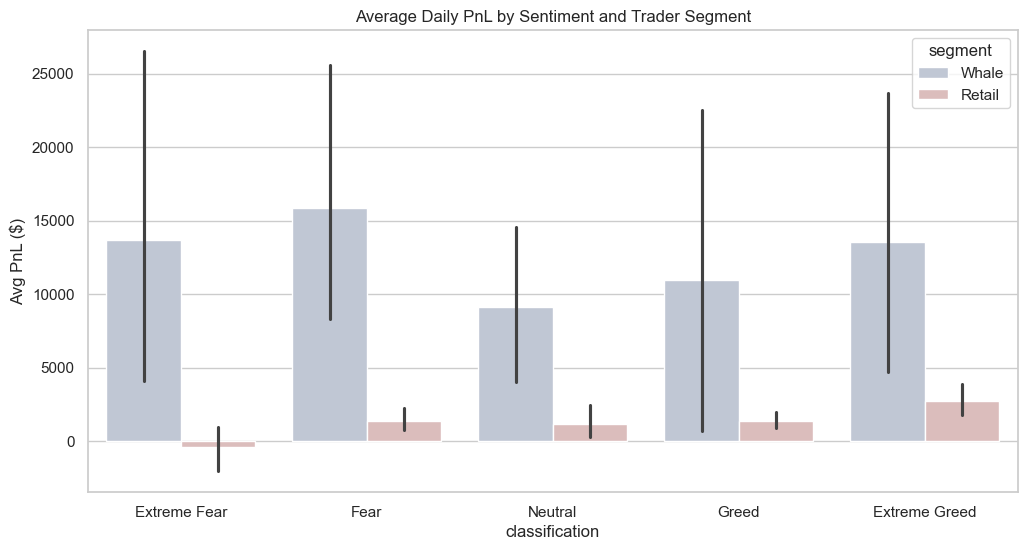

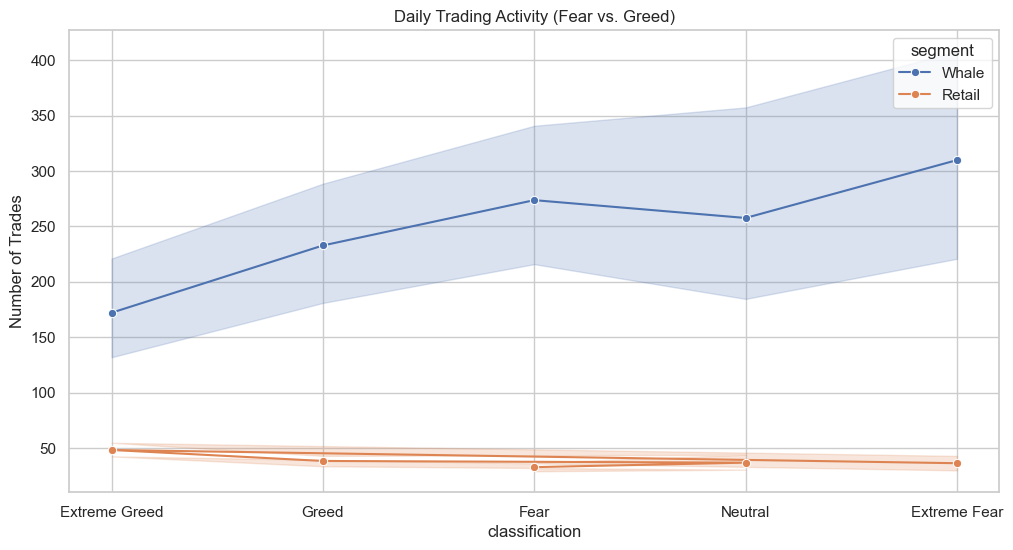

In [11]:
# Set visual style
sns.set_theme(style="whitegrid")

# Plot 1: Average PnL vs. Sentiment (To see who wins when)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_analysis, x='classification', y='daily_pnl', hue='segment', order=sentiment_order, palette='vlag')
plt.title('Average Daily PnL by Sentiment and Trader Segment')
plt.ylabel('Avg PnL ($)')
plt.savefig('pnl_vs_sentiment.png')

# Plot 2: Trade Frequency (To see "Panic" or "FOMO" behavior)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_analysis, x='classification', y='trade_count', hue='segment', marker='o', sort=False)
plt.title('Daily Trading Activity (Fear vs. Greed)')
plt.ylabel('Number of Trades')
plt.savefig('activity_vs_sentiment.png')

print("Section 5: Visualizations saved as .png files.")